#Mask R-CNN

In [97]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import warnings
warnings.filterwarnings("ignore")
model = maskrcnn_resnet50_fpn(pretrained=True).eval()

def preprocess_image(image_path):
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), np.array(Image.open(image_path).convert("RGB"))

def predict(image_path):
    image_tensor, image_np = preprocess_image(image_path)
    with torch.no_grad():
        predictions = model(image_tensor)
    return predictions, image_np

def calculate_iou_mask(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

def compute_iou_mask(image_path, ground_truth_box):
    predictions, _ = predict(image_path)
    pred_boxes = predictions[0]['boxes'].cpu().numpy() if len(predictions[0]['boxes']) > 0 else []

    iou_scores = [calculate_iou_mask(ground_truth_box, pred) for pred in pred_boxes] if len(pred_boxes) > 0 else [0]
    return max(iou_scores)

def visualize_predictions(image_path, predictions, threshold=0.5):
    image_tensor, image_np = preprocess_image(image_path)
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(image_np)

    for box, score, mask in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['masks']):
        if score > threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            mask_np = mask[0].cpu().numpy()
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
            ax.text(x1, y1, f"Score: {score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))
            color = [random.randint(0, 255) for _ in range(3)]
            mask_np = (mask_np > 0.5).astype(np.uint8)
            mask_overlay = np.zeros_like(image_np, dtype=np.uint8)

            for i in range(3):
                mask_overlay[:, :, i] = mask_np * color[i]

            image_np = cv2.addWeighted(image_np, 1, mask_overlay, 0.5, 0)

    ax.imshow(image_np)
    plt.show()



IoU for Mask R-CNN: 0.0987


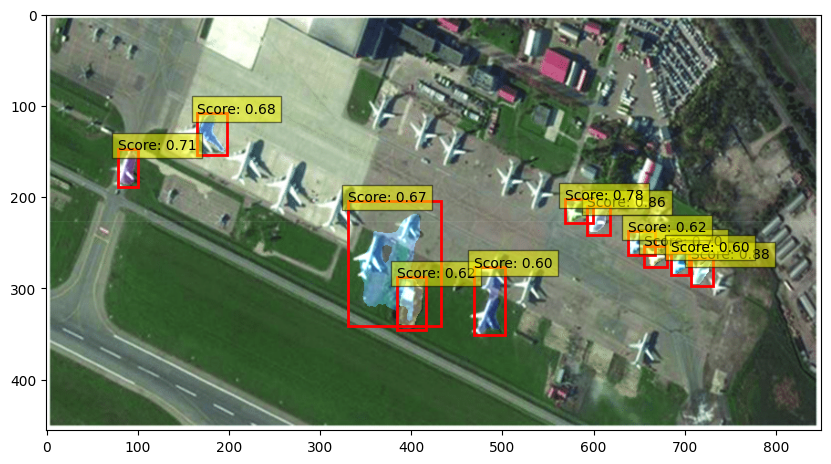

In [88]:
image_path = "img-1.png"
ground_truth_box = [50, 50, 200, 200]
predictions, _ = predict(image_path)
iou_mask_rcnn = compute_iou_mask(image_path, ground_truth_box)
print(f"IoU for Mask R-CNN: {iou_mask_rcnn:.4f}")
visualize_predictions(image_path, predictions)


IoU for Mask R-CNN: 0.2187


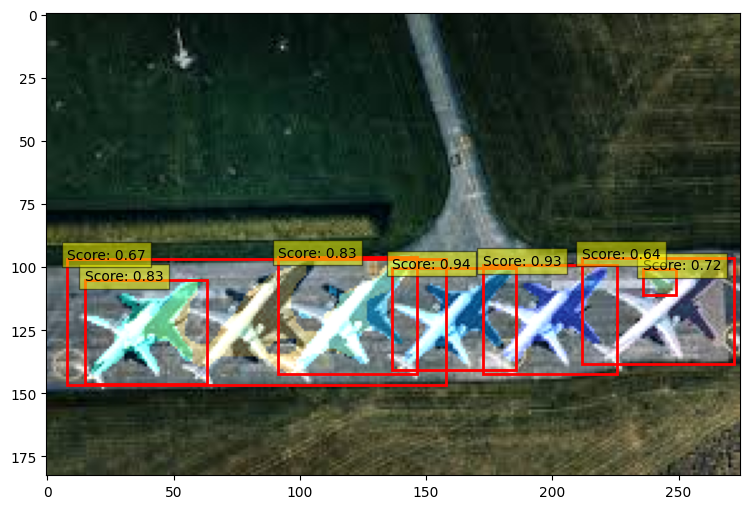

In [89]:
image_path = "img-2.jpg"
ground_truth_box = [50, 50, 200, 200]
predictions, _ = predict(image_path)
iou_mask_rcnn = compute_iou_mask(image_path, ground_truth_box)
print(f"IoU for Mask R-CNN: {iou_mask_rcnn:.4f}")
visualize_predictions(image_path, predictions)

#Faster R-CNN

In [90]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [91]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)


In [92]:
def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        predictions = model(image)
    return predictions


In [93]:
def show_predictions(image_path, predictions, threshold=0.5):
    image = np.array(Image.open(image_path).convert("RGB"))
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(image)

    for box, score in zip(predictions[0]['boxes'], predictions[0]['scores']):
        if score > threshold:
            x1, y1, x2, y2 = box.numpy()
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
            ax.text(x1, y1, f"Score: {score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

In [94]:
def calculate_iou_mask(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

model = fasterrcnn_resnet50_fpn(pretrained=True).eval()

def preprocess_image(image_path):
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        predictions = model(image)
    return predictions

def compute_iou(image_path, ground_truth_box):
    predictions = predict(image_path)
    pred_boxes = predictions[0]['boxes'].numpy() if len(predictions[0]['boxes']) > 0 else []

    iou_scores = [calculate_iou_mask(ground_truth_box, pred) for pred in pred_boxes] if len(pred_boxes) > 0 else [0]
    return max(iou_scores)




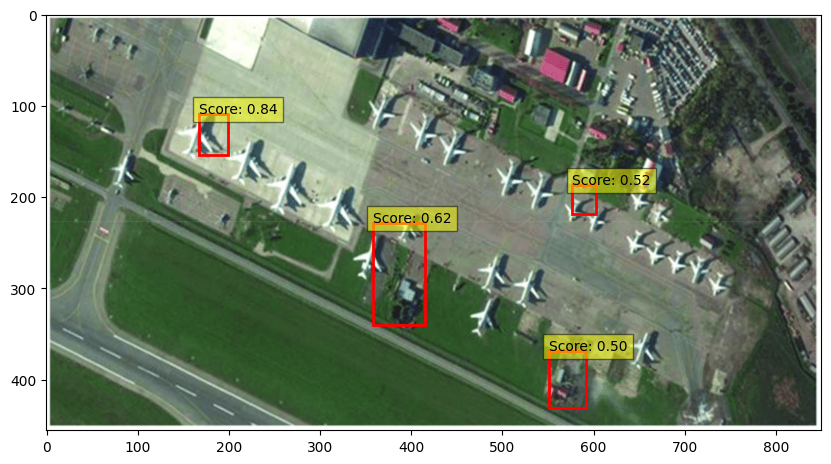

IoU for Faster R-CNN: 0.1614


In [95]:
image_path = "img-1.png"
predictions = predict(image_path)
show_predictions(image_path, predictions)
image_path = "img-1.png"
ground_truth_box = [50, 50, 200, 200]
iou_faster = compute_iou(image_path, ground_truth_box)
print(f"IoU for Faster R-CNN: {iou_faster:.4f}")

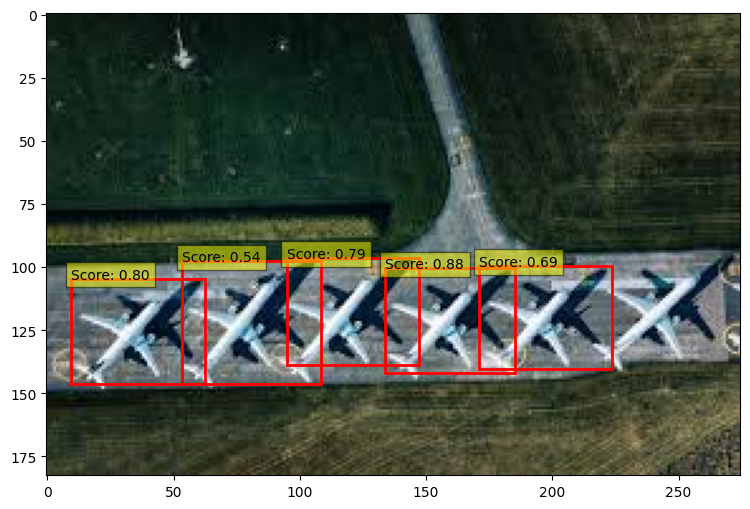

IoU for Faster R-CNN: 0.1614


In [96]:
image_path = "img-2.jpg"
predictions = predict(image_path)
show_predictions(image_path, predictions)
image_path = "img-1.png"
ground_truth_box = [50, 50, 200, 200]
iou_faster = compute_iou(image_path, ground_truth_box)

print(f"IoU for Faster R-CNN: {iou_faster:.4f}")